# CIS 545 Homework 2: Graphs

In [1]:
# Execute this once, the first time you run
#!pip install networkx

# Disable Python warning messages - you should probably only run this before submission

import warnings
warnings.filterwarnings('ignore')

## Step 2.1 Spark Setup

In [2]:
# TODO: Connect to Spark as per Step 2.1
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

spark = SparkSession.builder.appName('Graphs-HW2').getOrCreate()

In [3]:
# Load some dummy data, which should be overwritten in Step 2.2

answers_sdf = spark.createDataFrame([{'from_node': 123, 'to_node': 456},\
                                    {'from_node': 456, 'to_node': 789},
                                    {'from_node': 456, 'to_node': 890}])
comments_answers_sdf = spark.createDataFrame([{'from_node': 123, 'to_node': 456}])
comments_questions_sdf = spark.createDataFrame([{'from_node': 123, 'to_node': 456}])

graph_sdf = spark.createDataFrame([{'from_node': 123, 'to_node': 456}])

## Step 2.2 Loading

In [4]:
# TODO: load data as per Step 2.2
# Read lines from the text file

answers_sdf = spark.read.load('sx-stackoverflow-a2q.txt', 
                              format="text")
comments_answers_sdf = spark.read.load('sx-stackoverflow-c2a.txt', 
                              format="text")
comments_questions_sdf = spark.read.load('sx-stackoverflow-c2q.txt', 
                              format="text")


In [5]:
# You may add as many cells as you like here.
# Use Insert | Insert Cell Below

## Step 2.2 Results

In [6]:
answers_sdf.count()

17823525

In [7]:
answers_sdf.show(10)

+----------------+
|           value|
+----------------+
|  9 8 1217567877|
|  1 1 1217573801|
| 13 1 1217606247|
| 17 1 1217617639|
| 48 2 1217618182|
| 17 1 1217618239|
| 19 9 1217618357|
|13 23 1217618560|
|13 11 1217618799|
|23 23 1217619360|
+----------------+
only showing top 10 rows



In [8]:
answers_sdf.printSchema()

root
 |-- value: string (nullable = true)



In [9]:
comments_answers_sdf.count()

25405374

In [10]:
comments_answers_sdf.show(10)

+--------------------+
|               value|
+--------------------+
|     1 91 1220713630|
|     3 91 1220713792|
|  380 350 1220715736|
|4642 2257 1220734307|
|4642 1324220 1220...|
|2495 4285 1220736640|
|4642 4893 1220737355|
|2515 4903 1220738560|
|2515 4893 1220739071|
|  199 199 1220741079|
+--------------------+
only showing top 10 rows



In [11]:
comments_answers_sdf.printSchema()

root
 |-- value: string (nullable = true)



In [12]:
comments_questions_sdf.count()

20268151

In [13]:
comments_questions_sdf.show(10)

+--------------------+
|               value|
+--------------------+
|4550 4550 1220729190|
|  242 184 1220733503|
|4213 4946 1220768149|
|    91 91 1220768295|
|2658 1874 1220771891|
|4035 1874 1220773037|
|2257 4489 1220802041|
|  577 577 1220834891|
|4489 4489 1220853536|
| 828 2783 1220854143|
+--------------------+
only showing top 10 rows



In [14]:
comments_questions_sdf.printSchema()

root
 |-- value: string (nullable = true)



## Step 2.3

In [15]:
# TODO: wrangling work in Step 2.3.  Add as many Cells as you need

Create a temporary view (removed when the SparkSession ends) that allows us to run SQL queries against the contents of my_sdf

In [16]:
answers_sdf.createOrReplaceTempView('answers_sdf_view')


seperate the three columns under value that are seperated by single spaces

In [17]:
# using sql for answers_sdf
answers_sdf = spark.sql( """SELECT CAST(split(value, " ")[0] AS INTEGER) AS from_node,
    CAST(split(value, " ")[1] AS INTEGER) AS to_node,
    "answer" AS edge_type
    FROM answers_sdf_view""")


Note that I could also do this inspark without sql.

In [18]:
comments_answers_sdf = comments_answers_sdf.select( \
    F.split(comments_answers_sdf.value, " ")[0].alias("from_node").cast("int"), \
    F.split(comments_answers_sdf.value, " ")[1].alias("to_node").cast("int"), \
    F.split(comments_answers_sdf.value, " ")[2].alias("edge_type"))

In [19]:
comments_answers_sdf = comments_answers_sdf.withColumn('edge_type', F.lit("comment-on-answer"))

In [20]:
comments_questions_sdf = comments_questions_sdf.select( \
    F.split(comments_questions_sdf.value, " ")[0].alias("from_node").cast("int"), \
    F.split(comments_questions_sdf.value, " ")[1].alias("to_node").cast("int"), \
    F.split(comments_questions_sdf.value, " ")[2].alias("edge_type"))

In [21]:
comments_questions_sdf = comments_questions_sdf.withColumn('edge_type', F.lit("comment-on-question"))

Now use the Spark DataFrame unionAll function, or spark.sql() and the SQL UNION ALL operator, to create a single Spark DataFrame called graph_sdf, concatenating the results of all of the above, in the order answers_sdf, comments_questions_sdf, comments_answers_sdf.

In [22]:
# via spark
graph_sdf = answers_sdf.unionAll(comments_questions_sdf).unionAll(comments_answers_sdf)

Note that the code in the next block does exactly the same thing as the block above. Above uses spark and below uses SQL.

In [23]:
# via SQL
answers_sdf.createOrReplaceTempView('answers_sdf_view')
comments_answers_sdf.createOrReplaceTempView('comments_answers_sdf_view')
comments_questions_sdf.createOrReplaceTempView('comments_questions_sdf_view')
sql2graphsdf_cmd = "SELECT * FROM answers_sdf_view " + \
    "UNION " + \
    "SELECT * FROM comments_answers_sdf_view " + \
    "UNION " + \
    "SELECT * FROM comments_questions_sdf_view"
graph_sdf = spark.sql(sql2graphsdf_cmd)

## Step 2.3 Results

In [24]:
answers_sdf.count()

17823525

In [25]:
answers_sdf.show(5)

+---------+-------+---------+
|from_node|to_node|edge_type|
+---------+-------+---------+
|        9|      8|   answer|
|        1|      1|   answer|
|       13|      1|   answer|
|       17|      1|   answer|
|       48|      2|   answer|
+---------+-------+---------+
only showing top 5 rows



In [26]:
answers_sdf.printSchema()

root
 |-- from_node: integer (nullable = true)
 |-- to_node: integer (nullable = true)
 |-- edge_type: string (nullable = false)



In [27]:
comments_answers_sdf.count()

25405374

In [28]:
comments_answers_sdf.show(5)

+---------+-------+-----------------+
|from_node|to_node|        edge_type|
+---------+-------+-----------------+
|        1|     91|comment-on-answer|
|        3|     91|comment-on-answer|
|      380|    350|comment-on-answer|
|     4642|   2257|comment-on-answer|
|     4642|1324220|comment-on-answer|
+---------+-------+-----------------+
only showing top 5 rows



In [29]:
comments_answers_sdf.printSchema()

root
 |-- from_node: integer (nullable = true)
 |-- to_node: integer (nullable = true)
 |-- edge_type: string (nullable = false)



In [30]:
 comments_questions_sdf.count()

20268151

In [31]:
comments_questions_sdf.show(5)

+---------+-------+-------------------+
|from_node|to_node|          edge_type|
+---------+-------+-------------------+
|     4550|   4550|comment-on-question|
|      242|    184|comment-on-question|
|     4213|   4946|comment-on-question|
|       91|     91|comment-on-question|
|     2658|   1874|comment-on-question|
+---------+-------+-------------------+
only showing top 5 rows



In [32]:
comments_questions_sdf.printSchema()

root
 |-- from_node: integer (nullable = true)
 |-- to_node: integer (nullable = true)
 |-- edge_type: string (nullable = false)



In [33]:
graph_sdf.count()

38863566

In [34]:
graph_sdf.show(5)

+---------+-------+---------+
|from_node|to_node|edge_type|
+---------+-------+---------+
|        4| 686767|   answer|
|        4|1018689|   answer|
|        5|  97447|   answer|
|       13| 146603|   answer|
|       13| 210713|   answer|
+---------+-------+---------+
only showing top 5 rows



In [35]:
graph_sdf.printSchema()

root
 |-- from_node: integer (nullable = true)
 |-- to_node: integer (nullable = true)
 |-- edge_type: string (nullable = false)



## Step 2.4

In [36]:
# TODO: ind the user who has answered the most (highest number of) questions
answers_sdf.select( \
    answers_sdf.from_node.alias("user"), \
    answers_sdf.to_node).groupBy("user").agg( \
    F.count("to_node").alias("ansCounts")).orderBy( \
    "ansCounts", ascending=False).show(10)

+-------+---------+
|   user|ansCounts|
+-------+---------+
|  22656|    32030|
|1144035|    25146|
|  29407|    20842|
| 548225|    16944|
| 157882|    16615|
| 115145|    16515|
|  17034|    15437|
| 100297|    15020|
|   6309|    14291|
|  34397|    14033|
+-------+---------+
only showing top 10 rows



## Step 2.4.1 Results

In [37]:
# TODO: output dataframe with top 10 users by number of questions
graph_sdf.filter(graph_sdf["edge_type"].isin(['answer','comment-on-question'])).select( \
    graph_sdf.to_node.alias("user"), \
    graph_sdf.from_node).groupBy("user").agg( \
    F.count("from_node").alias("ansCounts")).orderBy( \
    "ansCounts", ascending=False).show(10)

+------+---------+
|  user|ansCounts|
+------+---------+
|  4653|     5212|
| 39677|     4572|
| 34537|     4234|
|179736|     3795|
|117700|     3532|
|875317|     3510|
| 84201|     3221|
| 65387|     3061|
|146780|     3021|
| 49153|     2838|
+------+---------+
only showing top 10 rows



In [38]:
# TODO: output top 10 users by number of answers to questions by distinct users
answers_sdf.select( \
    answers_sdf.from_node.alias("user"), \
    answers_sdf.to_node).distinct().groupBy("user").agg( \
    F.count("to_node").alias("ansCounts")).orderBy( \
    "ansCounts", ascending=False).show(10)

+-------+---------+
|   user|ansCounts|
+-------+---------+
|  22656|    22860|
|1144035|    21032|
| 548225|    14127|
|  29407|    13043|
| 115145|    12243|
|  19068|    12114|
| 100297|    11486|
|  34397|    11368|
|  17034|    11347|
|   6309|    11057|
+-------+---------+
only showing top 10 rows



## Step 2.4.2 Results

In [39]:
# TODO: number of users whose questions have never been answered or commented on
def unanswered(edget_list):
    if "comment-on-question" in edget_list and \
        "answer" not in edget_list:
        return(1)
    else:
        return(0)

In [40]:
sparkUnansweredF = F.udf(unanswered,  IntegerType())

In [41]:
unanswered_sdf = graph_sdf.filter(graph_sdf["edge_type"].isin(['answer','comment-on-question'])).select( \
    graph_sdf.to_node.alias("user"), \
    graph_sdf.edge_type).groupBy("user").agg( \
    F.collect_set("edge_type").alias(\
    "unanswered")).withColumn(\
    "unanswered",sparkUnansweredF("unanswered"))

In [42]:
unanswered_sdf.filter(unanswered_sdf["unanswered"] > 0).count()

150681

## Step 2.4.3 Results

In [43]:
# TODO: top 10 pairs of users by mutual answers, along with the number of questions they have mutually answered
def pairname(nodeA, nodeB):
    if nodeA > nodeB:
        return(str(nodeA)+";"+str(nodeB))
    elif(nodeB > nodeA):
        return(str(nodeB)+";"+str(nodeA))
    else:
        return(None)


In [44]:
sparkPairNameF = F.udf(pairname,  StringType())

I need to add a row for each pairID ("user1;user2") where user1>user2. Then I need to count the number of instances of each pairID (`ansCounts`). Then I need split up the pairID again to get a row for `user1` and `user2`

In [45]:
helpful_pairs_sdf = answers_sdf.select( \
    sparkPairNameF(answers_sdf.from_node, \
    answers_sdf.to_node).alias('pairID')).groupBy( \
    'pairID').agg(F.count("pairID").alias(\
    "ansCounts"))

In [46]:
helpful_pairs_sdf.select( \
    F.split(helpful_pairs_sdf.pairID, ";")[0].alias("user1").cast("int"), \
    F.split(helpful_pairs_sdf.pairID, ";")[1].alias("user2").cast("int"), \
    helpful_pairs_sdf.ansCounts).orderBy( \
    "ansCounts", ascending=False).show(10)

+-------+------+---------+
|  user1| user2|ansCounts|
+-------+------+---------+
| 742402|315935|      155|
|2258442|217408|      105|
| 399145|  6309|       81|
|1391249|157882|       78|
| 240337|157882|       76|
| 470184|  6309|       76|
| 167454| 91299|       73|
| 505088| 46207|       72|
| 988445|505088|       69|
| 366797| 15168|       65|
+-------+------+---------+
only showing top 10 rows



# Step 3

The higher the in-degree the more people have responded to the user's questions and answers. The higher the out-degre the more the user responds to other users.

In [47]:
# TODO: create `highest_indegree_sdf` with the 5 nodes with highest indegree
highest_indegree_sdf = graph_sdf.select(\
    graph_sdf.to_node).groupBy(\
    "to_node").agg(F.count("to_node").alias(\
    "indegree")).orderBy( \
    "indegree", ascending=False)

In [48]:
# TODO: create `highest_outdegree_sdf` with the 5 nodes with highest outdegree
highest_outdegree_sdf = graph_sdf.select(\
    graph_sdf.from_node).groupBy(\
    "from_node").agg(F.count("from_node").alias(\
    "outdegree")).orderBy( \
    "outdegree", ascending=False)

## Step 3 Results

In [49]:
highest_indegree_sdf.show(5)

+-------+--------+
|to_node|indegree|
+-------+--------+
|  22656|   22661|
|1144035|   14743|
|  29407|   12794|
| 548225|   10714|
| 115145|   10596|
+-------+--------+
only showing top 5 rows



## Step 4

In [50]:
highest_outdegree_sdf.show(5)

+---------+---------+
|from_node|outdegree|
+---------+---------+
|    22656|    44808|
|    17034|    39664|
|   118068|    35001|
|  1491895|    33166|
|  1144035|    32327|
+---------+---------+
only showing top 5 rows



In [51]:
# TODO: insert code as you like

#def formatPair(node, distance):
#    pair_n = ("(%s,%s)" % (node, distance))
#    return(pair_n)

In [52]:
#sparkFormatPairF = F.udf(formatPair,  StringType())

In [53]:
#
# Step 4.1 Pre-processing
#
def spark_bfs(G, origins, max_depth):
    
    schema = StructType([

            StructField("node", IntegerType(), True)

        ])


    return_sdf = spark.createDataFrame(origins, schema)
    return_sdf = return_sdf.withColumn('depth', F.lit(0))
    G.repartition(2, "from_node")
    G.cache()
    for i in range(1,max_depth+1):
        joined_sdf = return_sdf.join(comments_questions_sdf, \
            return_sdf.node == comments_questions_sdf.from_node)
        joined_sdf = joined_sdf.select( \
            joined_sdf.to_node.alias("node")).withColumn( \
        'depth', F.lit(i))
        joined_sdf = joined_sdf.join(return_sdf, \
            (joined_sdf.node == return_sdf.node), \
            'leftanti')
        return_sdf = return_sdf.unionAll(joined_sdf)
    
    return return_sdf

## Step 4.1

In [54]:
# TODO: comment out this line once your code is ready
#bfs_sdf = spark.createDataFrame([{'node': 123, 'depth': 1}, {'node': 456, 'depth': 2}])

# TODO: enable this once your code is ready
origin_map = [{'node': 4550}, {'node': 242}]
bfs_sdf = spark_bfs(comments_questions_sdf, origin_map, 2)
bfs_sdf.count()

397

In [55]:
bfs_sdf.show(10)

+-------+-----+
|   node|depth|
+-------+-----+
|   4550|    0|
|    242|    0|
|1619254|    1|
|2332659|    1|
|5504881|    1|
|1139389|    1|
|1940564|    1|
| 818089|    1|
|3047450|    1|
|4773326|    1|
+-------+-----+
only showing top 10 rows



## Step 4.2

In [56]:

#def formatPair(node, distance):
#    pair_n = ("(%s,%s)" % (node, distance))
#    return(pair_n)

In [60]:
#
# Step 4.2 Pre-processing
#
def friend_rec(filtered_bfs_sdf, graph_sdf):
    filtered_bfs_sdf.cache()
    ## Make copy of list of nodes we are interested in
    filtered_bfs_copy_sdf = filtered_bfs_sdf.select( \
        filtered_bfs_sdf.node.alias("to_node"))
    friend_recommendations_sdf = \
        filtered_bfs_sdf.join( \
        filtered_bfs_copy_sdf, \
        filtered_bfs_sdf.node != filtered_bfs_copy_sdf.to_node)
    friend_recommendations_sdf = friend_recommendations_sdf.select( \
        friend_recommendations_sdf.node.alias("from_node"), \
        friend_recommendations_sdf.to_node)
    graph_sdf.repartition(2, "from_node")
    poss_sdf = graph_sdf.join(filtered_bfs_sdf, \
        graph_sdf.from_node == filtered_bfs_sdf.node)
    poss_sdf = poss_sdf.select(poss_sdf.from_node, \
        poss_sdf.to_node)
    poss_sdf = poss_sdf.join(filtered_bfs_sdf, \
        poss_sdf.to_node == filtered_bfs_sdf.node)
    poss_sdf = poss_sdf.select(poss_sdf.from_node, \
        poss_sdf.to_node).filter(poss_sdf.from_node!=poss_sdf.to_node)
    poss_sdf_copy = poss_sdf.select( \
        poss_sdf.to_node.alias("from_node"), \
        poss_sdf.from_node.alias("to_node"))
    poss_sdf = poss_sdf.unionAll(poss_sdf_copy)
    
    
    #friend_recommendations_sdf = \
    #    friend_recommendations_sdf.select( \
    #    friend_recommendations_sdf.node.alias("from_node"), \
    #    friend_recommendations_sdf.to_node, \
    #    sparkPairNameF(friend_recommendations_sdf.node, \
    #    friend_recommendations_sdf.to_node).alias('pairID'))
    #friend_recommendations_sdf.repartition(2, "pairID")
    #pair_sdf = graph_sdf.select(sparkPairNameF( \
    #    graph_sdf.from_node, \
    #    graph_sdf.to_node).alias('pairID2'))
    
    friend_recommendations_sdf = \
        friend_recommendations_sdf.join(poss_sdf, \
            ((friend_recommendations_sdf.from_node == \
             poss_sdf.from_node) & \
             (friend_recommendations_sdf.to_node == \
             poss_sdf.to_node)), \
            'leftanti')
    #friend_recommendations_sdf = \
    #    friend_recommendations_sdf.select( \
    #    friend_recommendations_sdf.from_node, \
    #    friend_recommendations_sdf.to_node)
        
    return friend_recommendations_sdf
    #return poss_sdf

In [61]:
# get rows with distance of 2 and count rows per node
filtered_bfs_sdf = bfs_sdf.filter(bfs_sdf["depth"] == 2).groupBy("node").agg( \
    F.count("node").alias("parallel_edge_count"))
# remove nodes with only 1 instance
filtered_bfs_sdf = filtered_bfs_sdf.filter( \
    filtered_bfs_sdf["parallel_edge_count"] > 1)  
# drop `parallel_edge_count` column 
# add back `depth` column
filtered_bfs_sdf = filtered_bfs_sdf.select( \
            filtered_bfs_sdf.node).withColumn('depth', F.lit(2))

In [62]:
# TODO: comment this line out when your function works
#friend_recommendations_sdf = spark.createDataFrame([\
#                                                    {'from_node': 123, 'to_node': 456}, \
#                                                    {'from_node': 456, 'to_node': 123}])


# TODO: enable this when your function works

friend_recommendations_sdf = friend_rec(filtered_bfs_sdf, comments_questions_sdf)
friend_recommendations_sdf.count()

1804

## Step 4.2 Results

In [63]:
friend_recommendations_sdf.show()

+---------+-------+
|from_node|to_node|
+---------+-------+
|    21918| 453447|
|    21918|4204628|
|    46646| 267679|
|    59017|1187554|
|   104015|  55503|
|   211452|  59017|
|   503032|2269511|
|  1406214| 503032|
|  2269511|  21918|
|  3830157| 132640|
|  4204628|  47550|
|    46646|1127460|
|    55503| 104015|
|    60602|1187554|
|   267679|1061543|
|   393268| 318811|
|  1218595|1187554|
|  1218595|4800193|
|    27483|  46646|
|    63775|  46646|
+---------+-------+
only showing top 20 rows



## Step 4.3: Graph visualization

### Once you have excecuted the cells in Step 4.2 and you have friend_recommendations_sdf, lets create friend_recommendations_df using toPandas(). This creates an in-memory dataFrame that we can use to build the graph. Here we have used ('from_node','to_node') as column names in friend_recommendations_sdf, please change it to what you have used in yours.

In [64]:
import networkx as nx

# TODO: create friend_graph NetworkX graph from friend_recommendations_df from friend_recommendations_sdf
friend_graph_df = friend_recommendations_sdf.toPandas()
friend_graph = nx.from_pandas_dataframe(friend_graph_df,"from_node", "to_node")

## Step 4.3 Results

In [65]:
print ("Number of nodes (characters) in this graph is", friend_graph.order()) # number of nodes
print ("Number of edges in this graph is", len(friend_graph.edges())) # number of edges
print ("Graph diameter is", nx.diameter(friend_graph)) # maximum eccentricity

Number of nodes (characters) in this graph is 43
Number of edges in this graph is 902
Graph diameter is 2


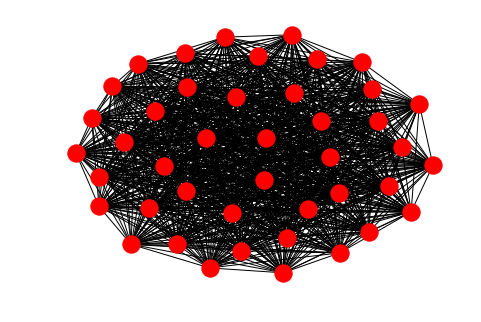

In [66]:
 %matplotlib inline
 nx.draw(friend_graph)